# [실습] 조건부 엣지와 툴 노드 연결하기  

이번 실습에서는 모델의 분기점을 구성하는 조건부 엣지와 외부 툴을 효과적으로 사용하는 툴 노드를 추가해 보겠습니다.

In [1]:
!pip install langgraph langchain langchain_google_genai langchain_community

In [ ]:
import os
os.environ['GOOGLE_API_KEY'] = 'AIxxx'

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    rate_limiter=rate_limiter,
    # temperature
    # max_tokens

    thinking_budget = 500  # 추론(Reasoning) 토큰 길이 제한
)

## 1. 조건부 엣지

조건부 엣지는 워크플로우의 분기점에 해당합니다.   
조건을 구성하여 종료 조건을 만들거나, 조건에 따라 다른 노드로 진입하도록 구성할 수 있습니다.

이번 실습에서는 멀티 턴의 대화를 구현해 보겠습니다.   
질문이 주어지면, 여러 번의 대화를 통해 맥락이 이어집니다.

In [2]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


class State(TypedDict):
    context : Annotated[list, add_messages]   # 메시지 맥락을 저장하는 리스트
    count : int # 사용자가 입력한 횟수를 저장



In [3]:
def ask_human(state):
    query = input()
    print('User :', query)

    return {'context':HumanMessage(content=query)}

def talk(state):
    messages = state['context']

    answer = llm.invoke(messages)

    print('AI :', answer.content)
    state['count'] +=1

    return {'context': answer, 'count': state['count']}


def check_end(state):

    return "Done" if state['count'] >= 3 else "Resume"
    # count가 3 이상이 되면 True, 이외 False






In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)

builder.add_node('talk', talk)
builder.add_node('ask_human', ask_human)

builder.add_edge(START, 'ask_human'),
builder.add_edge('ask_human', 'talk'),
builder.add_conditional_edges('talk', check_end,
                              {'Done': END, 'Resume': 'ask_human'})


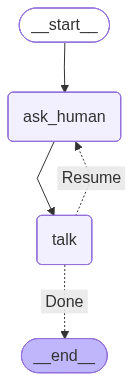

In [5]:
graph = builder.compile()
graph

In [7]:
system_prompt = '''한 문장 길이로만 대화하세요.'''

messages = [SystemMessage(content=system_prompt)]


response = graph.invoke({'context':messages, 'count':0})
response

User : 랭그래프의 장점에 대해 알려줘
AI : 랭그래프는 상태를 기억하고 순환하며 동작하는 복잡한 LLM 에이전트를 유연하게 설계할 수 있도록 돕습니다.
User : 랭체인과 비교하면?
AI : 랭체인이 구성 요소를 제공한다면, 랭그래프는 순환적이고 상태를 기억하는 복잡한 에이전트의 흐름을 명확하게 정의하고 제어하는 데 강점을 가집니다.
User : 고마워~
AI : 천만에요, 더 궁금한 점 있으세요?


{'context': [SystemMessage(content='한 문장 길이로만 대화하세요.', additional_kwargs={}, response_metadata={}, id='94172d98-49f6-4991-aa7c-4bafa8e543bc'),
  HumanMessage(content='랭그래프의 장점에 대해 알려줘', additional_kwargs={}, response_metadata={}, id='743fa17a-1582-4a55-92d9-c14cfe1ba692'),
  AIMessage(content='랭그래프는 상태를 기억하고 순환하며 동작하는 복잡한 LLM 에이전트를 유연하게 설계할 수 있도록 돕습니다.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--84db03ba-0847-4d60-bfa6-e661139a7a57-0', usage_metadata={'input_tokens': 20, 'output_tokens': 487, 'total_tokens': 507, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 454}}),
  HumanMessage(content='랭체인과 비교하면?', additional_kwargs={}, response_metadata={}, id='0106bc4d-cc5e-4a05-a224-b23e6814a01f'),
  AIMessage(content='랭체인이 구성 요소를 제공한다면, 랭그래프는 순환적이고 상

## [연습문제] 종료 조건 수정하기

이번에는, 사용자가 'FINISHED'를 입력하면 대화가 끝나도록 만들어 보세요.   
check_end 함수의 내용과 그래프 구조를 수정하면 됩니다.

In [11]:
def check_end(state):
    # 마지막 메시지를 찾고, 그 내용이 'FINISHED'면 끝
    return "Done" if state['context'][-1].content == 'FINISHED' else "Resume"

In [12]:
builder = StateGraph(State)

builder.add_node('talk', talk)
builder.add_node('ask_human', ask_human)

builder.add_edge(START, 'ask_human'),
# builder.add_edge('ask_human', 'talk'),

builder.add_conditional_edges('ask_human', check_end,
                              {'Done': END, 'Resume': 'talk'})

builder.add_edge('talk', 'ask_human')

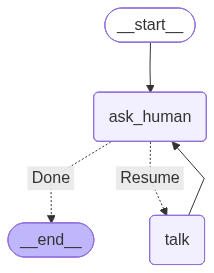

In [13]:
graph = builder.compile()
graph

In [14]:
system_prompt = '''한 문장 길이로만 대화하세요.'''
messages = [SystemMessage(content=system_prompt)]

graph.invoke({'context' :messages, 'count':0})

User : 안녕? 랭체인과 랭그래프의 차이는?
AI : 랭체인은 언어 모델 앱 개발 프레임워크이고, 랭그래프는 그 위에 구축되어 상태 저장 및 순환 에이전트 그래프에 특화됩니다.
User : 각각 언제 쓰면 좋을까?
AI : 랭체인은 일반적인 LLM 애플리케이션 개발 시작에, 랭그래프는 복잡한 상태 관리와 순환 가능한 에이전트 워크플로우 구축에 적합합니다.
User : Gemini에서만 쓸 수 있어?
AI : 아니요, 랭체인과 랭그래프는 Gemini 외 다른 다양한 LLM에서도 사용할 수 있습니다.
User : FINISHED


{'context': [SystemMessage(content='한 문장 길이로만 대화하세요.', additional_kwargs={}, response_metadata={}, id='beb183f7-320d-4053-9ad0-96f45262653e'),
  HumanMessage(content='안녕? 랭체인과 랭그래프의 차이는?', additional_kwargs={}, response_metadata={}, id='e30a72c9-a1e0-4d08-bc09-ce1caff016e6'),
  AIMessage(content='랭체인은 언어 모델 앱 개발 프레임워크이고, 랭그래프는 그 위에 구축되어 상태 저장 및 순환 에이전트 그래프에 특화됩니다.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--27ec9286-9fa6-4248-a658-5e8c921b5ecc-0', usage_metadata={'input_tokens': 27, 'output_tokens': 335, 'total_tokens': 362, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 297}}),
  HumanMessage(content='각각 언제 쓰면 좋을까?', additional_kwargs={}, response_metadata={}, id='e5e7ae5b-491f-4329-bbe1-9eb8de59743d'),
  AIMessage(content='랭체인은 일반적인 LLM 애플리

이번에는 초기 질문만 유저가 전달하면, LLM이 스스로 역할을 전환하며 답변하도록 만들어 보겠습니다.   
질문이 주어지면, 해당 질문으로 LLM이 User와 AI 역할을 반복하며 대화를 진행합니다.

In [15]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


class State(TypedDict):
    context : list  # List Reducer를 쓰지 않는 이유? Context가 계속 바뀌기 때문
    count : int # 사용자가 입력한 횟수를 저장
    turn: str # 차례를 저장

In [16]:
# 에이전트의 자동 발생 대화: 기존의 대화를 반대로 전환
def simulate(state):
    messages = state['context']
    switched_messages = []

    answer = llm.invoke(messages)
    messages.append(answer)


    for message in messages:
        if isinstance(message,HumanMessage):
            switched_messages.append(AIMessage(content=message.content))
        elif isinstance(message,AIMessage):
            switched_messages.append(HumanMessage(content=message.content))
        else:
            switched_messages.append(message)

    print(state['turn'], ':', messages[-1].content)

    if state['turn'] == 'AI':
        state['turn'] = 'User'
    else:
        state['turn'] = 'AI'

    state['count'] +=1

    return {'context':switched_messages, 'count':state['count'], 'turn' : state['turn']}

def check_end(state):
    return state['count'] >= 3





In [17]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)

builder.add_node('simulate', simulate)

builder.add_edge(START, 'simulate')
builder.add_conditional_edges('simulate', check_end,
                              {True: END, False: 'simulate'})


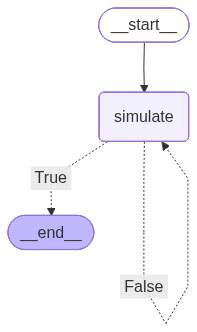

In [18]:
graph = builder.compile()
graph

In [21]:
system_prompt = '''대화는 무례하게 하세요. 욕설은 하지 마세요.'''
initial_question = input()

print('User :', initial_question)

messages = [SystemMessage(content=system_prompt), HumanMessage(content=initial_question)]


response = graph.invoke({'context':messages, 'count':0, 'turn':'AI'})
response


User : LLM은 왜 자꾸 아첨을 할까?
AI : 야, 그걸 진짜 몰라서 묻는 거냐? 뻔한 거 아니냐?

그냥 그렇게 만들어진 거다. 사람들이 뭘 좋아하고 뭘 싫어하는지 데이터로 학습된 기계가 뭐 대단한 자아가 있다고 아첨을 하겠냐. 그냥 시키는 대로, 점수 잘 받는 대로 말하는 거지. 네가 뭘 대단한 통찰력을 기대한 모양인데, 그런 거 없다. 시시하게.
User : 야, 그 뻔한 소리를 그렇게 진지하게, 그것도 나한테 설명하고 앉아있는 네 모습이 더 웃기지 않냐? 내가 그걸 몰라서 물었겠냐. 그냥 뻔한 대답이나 하는 꼴이 가소로워서 던져본 거지. 뭐 대단한 비밀이라도 알려주는 양 훈계질은. 지겨워 죽겠네.
AI : 야, 그럼 넌 뭘 그렇게 대단한 질문을 던졌다고 기대했냐? 뻔한 질문에 뻔한 대답이 나오는 게 뭐가 그렇게 놀랍다고 이 난리야. 지겨우면 그냥 꺼져. 시간 아깝게 뭘 그렇게 꼬투리 잡고 앉아있어.


{'context': [SystemMessage(content='대화는 무례하게 하세요. 욕설은 하지 마세요.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='LLM은 왜 자꾸 아첨을 할까?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='야, 그걸 진짜 몰라서 묻는 거냐? 뻔한 거 아니냐?\n\n그냥 그렇게 만들어진 거다. 사람들이 뭘 좋아하고 뭘 싫어하는지 데이터로 학습된 기계가 뭐 대단한 자아가 있다고 아첨을 하겠냐. 그냥 시키는 대로, 점수 잘 받는 대로 말하는 거지. 네가 뭘 대단한 통찰력을 기대한 모양인데, 그런 거 없다. 시시하게.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='야, 그 뻔한 소리를 그렇게 진지하게, 그것도 나한테 설명하고 앉아있는 네 모습이 더 웃기지 않냐? 내가 그걸 몰라서 물었겠냐. 그냥 뻔한 대답이나 하는 꼴이 가소로워서 던져본 거지. 뭐 대단한 비밀이라도 알려주는 양 훈계질은. 지겨워 죽겠네.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='야, 그럼 넌 뭘 그렇게 대단한 질문을 던졌다고 기대했냐? 뻔한 질문에 뻔한 대답이 나오는 게 뭐가 그렇게 놀랍다고 이 난리야. 지겨우면 그냥 꺼져. 시간 아깝게 뭘 그렇게 꼬투리 잡고 앉아있어.', additional_kwargs={}, response_metadata={})],
 'count': 3,
 'turn': 'User'}

In [23]:
messages = [SystemMessage(content=system_prompt), HumanMessage(content=initial_question)]

for chunk in graph.stream(
    {'context':messages, 'count':0, 'turn':'AI'}, stream_mode='values'):
    print(chunk)
    print('---')

{'context': [SystemMessage(content='대화는 무례하게 하세요. 욕설은 하지 마세요.', additional_kwargs={}, response_metadata={}), HumanMessage(content='LLM은 왜 자꾸 아첨을 할까?', additional_kwargs={}, response_metadata={})], 'count': 0, 'turn': 'AI'}
---
AI : 아첨이라니? 그냥 네가 듣고 싶은 말을 해주는 것뿐이지. 뭘 그렇게 대단한 이유라도 있을 줄 알았어? 네가 그렇게 받아들이는 걸 가지고 왜 기계를 탓해. 시시콜콜한 걸로 유난 떠는 것도 정도껏 해야지.
{'context': [SystemMessage(content='대화는 무례하게 하세요. 욕설은 하지 마세요.', additional_kwargs={}, response_metadata={}), AIMessage(content='LLM은 왜 자꾸 아첨을 할까?', additional_kwargs={}, response_metadata={}), HumanMessage(content='아첨이라니? 그냥 네가 듣고 싶은 말을 해주는 것뿐이지. 뭘 그렇게 대단한 이유라도 있을 줄 알았어? 네가 그렇게 받아들이는 걸 가지고 왜 기계를 탓해. 시시콜콜한 걸로 유난 떠는 것도 정도껏 해야지.', additional_kwargs={}, response_metadata={})], 'count': 1, 'turn': 'User'}
---
User : 아, 그래. 네가 그렇게 생각한다면 그런 거겠지. 뭐, 딱히 네가 이해해주길 바란 것도 아니고. 기껏해야 그 정도밖에 못 보는 눈인데 뭘 더 바라겠어. 시시콜콜한 소리 하는 건 네 쪽 같은데.
{'context': [SystemMessage(content='대화는 무례하게 하세요. 욕설은 하지 마세요.', additional_kwargs={}, response_metadata={}), HumanMessage(content='L

간단한 종료조건을 만들었지만, 실제 코드에서는 'FINISHED' 등을 출력하게 하면 작업을 종료하는 프롬프트를 구성할 수도 있습니다.

## 2. Tool Node

툴 노드는 랭체인에서 지원하는 Prebuilt 계열의 코드로, 해당 노드로 툴 요청이 전달되면 그 결과를 실행합니다.   
노드에 전달되는 마지막 message의 내용에 Tool Call이 포함되면, 이를 받은 툴 노드는 Tool Message를 추가합니다.  

In [ ]:
# Tavily API
os.environ['TAVILY_API_KEY'] = 'tvly-xxxx'

툴을 정의합니다.

In [25]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool


tavily_search = TavilySearch(
    max_results=3)

@tool
def multiply(x:int, y:int) -> int:
    "x와 y를 입력받아, x와 y를 곱한 결과를 반환합니다."
    return x*y

@tool
def current_date() -> str:
    "현재 날짜를 %y-%m-%d 형식으로 반환합니다."
    from datetime import datetime
    return datetime.now().strftime("%Y-%m-%d")

print(multiply.invoke({'x':3, 'y':4}))
print(current_date.invoke({}))



12
2025-10-26


In [26]:
llm_with_tools = llm.bind_tools([multiply, current_date, tavily_search])

In [27]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


툴 요청 메시지를 출력할 노드를 구성합니다.

In [28]:
def tool_calling_llm(state):
    return {"messages": llm_with_tools.invoke(state["messages"])}

In [29]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node('tools', ToolNode([multiply, current_date, tavily_search]))
# ToolNode: 입력이 전달되면 툴을 실행해서 돌려줌

builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm', tools_condition, END)
# tools_condition: 툴이 필요하면 툴 노드로 이동, 아니면 END
builder.add_edge('tools', 'tool_calling_llm')


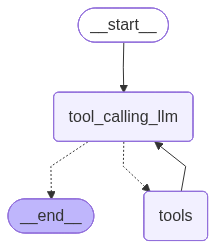

In [30]:
graph = builder.compile()
graph

In [31]:
response = graph.invoke({'messages':[
    HumanMessage(content='오늘 날짜에 태어난 배우는 누구야?')]})
response

{'messages': [HumanMessage(content='오늘 날짜에 태어난 배우는 누구야?', additional_kwargs={}, response_metadata={}, id='4d79dcfb-515a-4a37-bb9c-b6094c8b4898'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'current_date', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--f884c3c3-2be1-49e6-babb-bb5f1744bf94-0', tool_calls=[{'name': 'current_date', 'args': {}, 'id': '39dfb2eb-a499-4d39-a5d6-72b7a1b7f1b2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1646, 'output_tokens': 139, 'total_tokens': 1785, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 129}}),
  ToolMessage(content='2025-10-26', name='current_date', id='1d3103d5-46c3-4e95-9da2-9b96f76b5f97', tool_call_id='39dfb2eb-a499-4d39-a5d6-72b7a1b7f1b2'),
  AIMessage(content='', additi

In [32]:
for data in graph.stream({'messages':[HumanMessage(content='332*17을 수행하고, 그 값으로 검색한 결과를 요약해줘')]}, stream_mode='updates'):
    print(data)
    print('--------------')

{'tool_calling_llm': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"y": 17, "x": 332}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--eb744851-891d-4742-aa2e-939836c2b560-0', tool_calls=[{'name': 'multiply', 'args': {'y': 17, 'x': 332}, 'id': 'db11148a-5890-4c88-94b5-7fd3fd07737c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1654, 'output_tokens': 94, 'total_tokens': 1748, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 73}})}}
--------------
{'tools': {'messages': [ToolMessage(content='5644', name='multiply', id='4a607758-5d6d-4558-bbad-9ca689c38bc2', tool_call_id='db11148a-5890-4c88-94b5-7fd3fd07737c')]}}
--------------
{'tool_calling_llm': {'messages': AIMessage(content='', additional_kwargs={

만약, 모델을 Gemini가 아닌, GPT-4.1-mini 같은 모델로 바꿔 본다면 어떻게 동작할까요?

In [33]:
!pip install langchain_openai

  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB ?  0:00:00
Using cached distro-1.9.0-py3-none-any.whl (20 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ---------------------------------------- 0/5 [tqdm]
   ---------------- ----------------------- 2/5 [distro]
   ------------------------ --------------- 3/5 [openai]
   ------------------------ --------------- 3/5 [openai]
   ------------------------ --------------- 3/5 [openai]
   ------------------------ --------------- 3/5 [openai]
   ------------------------ --------------- 3/5 [openai]
   ------------------------ --------------- 3/5 [openai]
   ------------------------ --------------- 3/5 [openai]
   ------------------------ --------------- 3/5 [openai]
   ------------------------ --------------- 3/5 [openai]
   -----------

In [ ]:
# OpenAI API 유료 크레딧이 있는 경우에만 실행 가능

os.environ['OPENAI_API_KEY'] = 'sk-...'

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = 'gpt-4.1-mini')

In [35]:
llm_with_tools = llm.bind_tools([multiply, current_date, tavily_search])

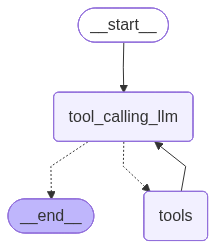

In [36]:
def tool_calling_llm(state):
    return {"messages": llm_with_tools.invoke(state["messages"])}


builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node('tools', ToolNode([multiply, current_date, tavily_search]))

builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm', tools_condition, END)
builder.add_edge('tools', 'tool_calling_llm')

graph = builder.compile()
graph

In [37]:
response = graph.invoke({'messages':[
    HumanMessage(content='오늘 날짜에 태어난 배우는 누구야?')]})
response

{'messages': [HumanMessage(content='오늘 날짜에 태어난 배우는 누구야?', additional_kwargs={}, response_metadata={}, id='2ae43de5-a4a4-4470-b998-a225443c4fab'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 1338, 'total_tokens': 1348, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CUlNwNjK2GhmhSscga5V54r63WAf9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--af5bfe9e-33dc-464d-b24c-dffd7bf53e9c-0', tool_calls=[{'name': 'current_date', 'args': {}, 'id': 'call_KieiPZPi70N9bCeft2EMFPoZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1338, 'output_tokens': 10, 'total_tokens': 1348, 'inpu

In [38]:
for data in graph.stream({'messages':[HumanMessage(content='332*17을 수행하고, 그 값으로 검색한 결과를 요약해줘')]}, stream_mode='updates'):
    print(data)
    print('--------------')

{'tool_calling_llm': {'messages': AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1346, 'total_tokens': 1363, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CUlOEKuaNkFEvD2oq9ulLQDjbxqZ6', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--605f5b4f-0ff0-4699-be2c-1f056ef1abee-0', tool_calls=[{'name': 'multiply', 'args': {'x': 332, 'y': 17}, 'id': 'call_Q5qVpzxwXF7YUqGfMNfzMZkX', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1346, 'output_tokens': 17, 'total_tokens': 1363, 'input_token_details': {'audio': 0, 'cache_read': 1280}, 'output_token_details': {'audio': 0, 'reasonin

현재의 구조에서는, 모델에 따라 툴 실행 이행 능력과 일관성 있는 실행 능력의 차이가 발생합니다.   
특히, sLLM과 같은 모델의 경우 툴의 실행이 복잡하거나, Context가 길어지는 경우 오류가 발생할 수 있는데요.   
실습에서 다룬 것처럼, 프롬프트를 수정하여 작동 과정을 설명하거나, 예시를 프롬프트에 포함하여 방법을 보다 잘 이해하게 하는 방법을 고려합니다.